Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [8]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

In [9]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (450000, 28, 28) (450000,)
Validation set (30000, 28, 28) (30000,)
Test set (15000, 28, 28) (15000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [10]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    # None refers to new axis
  labels = np.squeeze(labels)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (450000, 28, 28, 1) (450000, 10)
Validation set (30000, 28, 28, 1) (30000, 10)
Test set (15000, 28, 28, 1) (15000, 10)


In [11]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))

  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.999866
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 100: 0.951546
Minibatch accuracy: 75.0%
Validation accuracy: 69.5%
Minibatch loss at step 200: 0.925456
Minibatch accuracy: 81.2%
Validation accuracy: 77.9%
Minibatch loss at step 300: 0.275925
Minibatch accuracy: 87.5%
Validation accuracy: 79.5%
Minibatch loss at step 400: 0.272790
Minibatch accuracy: 93.8%
Validation accuracy: 80.7%
Minibatch loss at step 500: 0.815240
Minibatch accuracy: 87.5%
Validation accuracy: 80.7%
Minibatch loss at step 600: 0.328734
Minibatch accuracy: 87.5%
Validation accuracy: 81.9%
Minibatch loss at step 700: 0.965434
Minibatch accuracy: 68.8%
Validation accuracy: 82.2%
Minibatch loss at step 800: 0.539419
Minibatch accuracy: 87.5%
Validation accuracy: 83.1%
Minibatch loss at step 900: 0.621945
Minibatch accuracy: 87.5%
Validation accuracy: 83.4%
Minibatch loss at step 1000: 0.464892
Minibatch accuracy: 87.5%
Validation accuracy: 82.8%


---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))

  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    max_pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(max_pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    max_pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')
    
    shape = max_pool.get_shape().as_list()
    reshape = tf.reshape(max_pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [8]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.690925
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 100: 1.158840
Minibatch accuracy: 50.0%
Validation accuracy: 57.6%
Minibatch loss at step 200: 0.883132
Minibatch accuracy: 75.0%
Validation accuracy: 77.2%
Minibatch loss at step 300: 0.332607
Minibatch accuracy: 87.5%
Validation accuracy: 79.2%
Minibatch loss at step 400: 0.307756
Minibatch accuracy: 93.8%
Validation accuracy: 80.3%
Minibatch loss at step 500: 0.727460
Minibatch accuracy: 87.5%
Validation accuracy: 80.8%
Minibatch loss at step 600: 0.387624
Minibatch accuracy: 87.5%
Validation accuracy: 82.5%
Minibatch loss at step 700: 0.848215
Minibatch accuracy: 75.0%
Validation accuracy: 83.1%
Minibatch loss at step 800: 0.653175
Minibatch accuracy: 75.0%
Validation accuracy: 83.6%
Minibatch loss at step 900: 0.617728
Minibatch accuracy: 87.5%
Validation accuracy: 83.9%
Minibatch loss at step 1000: 0.325244
Minibatch accuracy: 93.8%
Validation accuracy: 83.8%

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

Let's build a small network with 2*(convolution layer + max pooling), followed by 2 fully connected layers, with L2 regulation

In [12]:
batch_size = 16
patch_size = 5
depth_1 = 32
depth_2 = 32
num_hidden_1 = 64
num_hidden_2 = 32
decay_steps = 500
decay_rate = 0.8
image_size = 28
num_channels = 1
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_beta_regul = tf.placeholder(tf.float32)

  global_step = tf.Variable(0)  # count the number of steps taken.
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth_1], stddev=0.5*np.sqrt(2.0/patch_size)))
  layer1_biases = tf.Variable(tf.zeros([depth_1]))
    
  conv1_weights = tf.Variable(tf.truncated_normal(
      [1, 1, depth_1, depth_1], stddev=0.1))
    
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth_1, depth_2], stddev=0.5*np.sqrt(2.0/patch_size)))
  layer2_biases = tf.Variable(tf.zeros([depth_2]))
    
  conv2_weights = tf.Variable(tf.truncated_normal(
      [1, 1, depth_2, depth_2], stddev=0.1))
    
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth_2, num_hidden_1], 
      stddev=np.sqrt(2.0/(image_size // 4 * image_size // 4 * depth_2))))
  layer3_biases = tf.Variable(tf.zeros([num_hidden_1]))
    
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_1, num_hidden_2], stddev=np.sqrt(2.0/num_hidden_1)))
  layer4_biases = tf.Variable(tf.zeros([num_hidden_2]))  
    
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_2, num_labels], stddev=np.sqrt(2.0/num_hidden_2)))
  layer5_biases = tf.Variable(tf.zeros([num_labels]))
  
  # Model.
  def model(data):
    # convolution 1
    conv_temp = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    
    # 1*1 convolutions
    conv = tf.nn.conv2d(conv_temp, conv1_weights, [1, 1, 1, 1], padding='SAME')
    
    # relu
    hidden = tf.nn.relu(conv + layer1_biases)
    
    # max pooling
    max_pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')
   
    hidden = tf.nn.dropout(max_pool, 0.5)
    
    # convolution 2
    conv_temp = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    
    # 1*1 convolutions
    conv = tf.nn.conv2d(conv_temp, conv2_weights, [1, 1, 1, 1], padding='SAME')
    
    #relu
    hidden = tf.nn.relu(conv + layer2_biases)
    # max pooling
    max_pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')

    hidden = tf.nn.dropout(max_pool, 0.5)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # fully connected 1
    y1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    #y1 = tf.nn.dropout(y1, 0.5) 
    
    # fully connected 2
    y2 = tf.nn.relu(tf.matmul(y1, layer4_weights) + layer4_biases)
    #y2 = tf.nn.dropout(y2, 0.5) 
    
    return tf.matmul(y2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * (tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights
    ))
    
  # Learning rate
  learning_rate = tf.train.exponential_decay(0.05, global_step, decay_steps, decay_rate)
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(
      learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [13]:
num_steps = 15001
num_step = []
validation_accuracy = []
beta_regul = 0.00055

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                tf_beta_regul: beta_regul}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      num_step.append(step)
      validation_accuracy.append(accuracy(
        valid_prediction.eval(), valid_labels))
        
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.128408
Minibatch accuracy: 6.2%
Validation accuracy: 11.0%
Minibatch loss at step 500: 0.786134
Minibatch accuracy: 75.0%
Validation accuracy: 77.3%
Minibatch loss at step 1000: 1.313252
Minibatch accuracy: 62.5%
Validation accuracy: 80.0%
Minibatch loss at step 1500: 0.806804
Minibatch accuracy: 81.2%
Validation accuracy: 82.1%
Minibatch loss at step 2000: 0.362791
Minibatch accuracy: 81.2%


KeyboardInterrupt: 

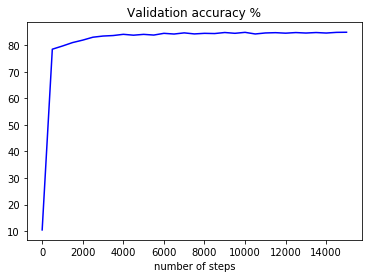

In [17]:
  plt.plot(num_step, validation_accuracy, 'b-')
  plt.title('Validation accuracy %')
  plt.xlabel('number of steps')
  plt.show()